In [1]:
# standard
import os, sys

import csv
from collections import defaultdict
import datetime 
from typing import Tuple, List, Dict, DefaultDict

# third party
from delphi_epidata import Epidata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')

# first party
sys.path.append('/Users/mjahja/Delphi/covidcast-nowcast/')

from delphi_covidcast_nowcast.data_containers import LocationSeries, SignalConfig
from delphi_covidcast_nowcast.deconvolution.deconvolution import deconvolve_signal, TempEpidata
import delphi_covidcast_nowcast.deconvolution.delay_kernel as delay
import delphi_covidcast_nowcast.nowcast as nowcast
from delphi_covidcast_nowcast.nowcast_fusion import covariance, fusion
from delphi_covidcast_nowcast.sensorization import sensor
from delphi_covidcast_nowcast.statespace.statespace import generate_statespace

In [2]:
regression_indicators = [SignalConfig('fb-survey', 'smoothed_hh_cmnty_cli', 'fb', 3)]
convolved_truth_indicator = SignalConfig('usa-facts', 'confirmed_incidence_num',
                                         '', 0)
sensor_indicators = [convolved_truth_indicator] + regression_indicators

as_of_date = 20200615
input_dates = list(range(20200501, 20200615))
input_locations = [('pa', 'state'),
                   ('42003', 'county'),
                   ('42005', 'county'),
                   ('42101', 'county')]
kernel = delay.get_florida_delay_distribution()

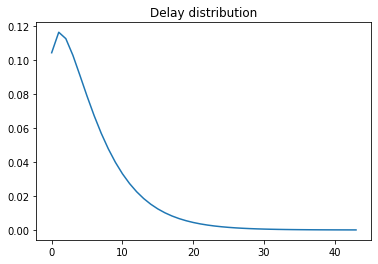

In [3]:
plt.plot(kernel)
plt.title("Delay distribution")
plt.show()

### Deconvolved ground truth

In [4]:
ground_truth = deconvolve_signal(convolved_truth_indicator, input_dates,
                                 input_locations, np.array(kernel))

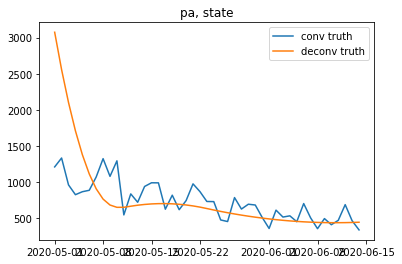

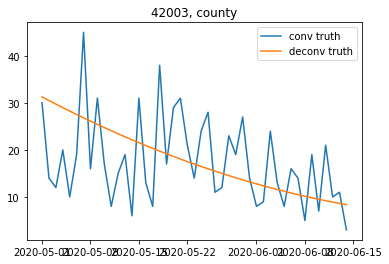

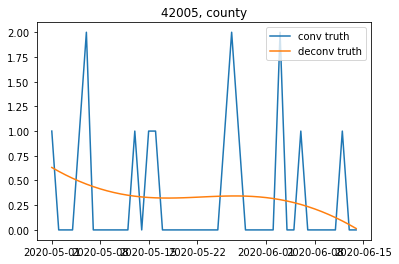

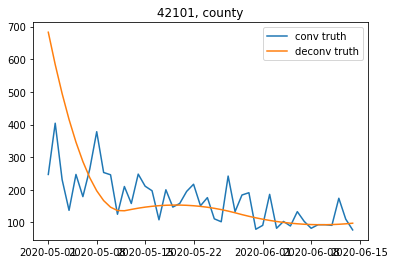

In [5]:
for signal in ground_truth:
    conv_truth = TempEpidata.get_signal_range(
        convolved_truth_indicator.source,
        convolved_truth_indicator.signal,
        input_dates[0], input_dates[-1],
        signal.geo_type, signal.geo_value)
    
    dates = list(map(TempEpidata.to_date, signal.dates))
    plt.plot(dates, conv_truth.values, label="conv truth")
    plt.plot(dates, signal.values, label="deconv truth")
    plt.title(f"{signal.geo_value}, {signal.geo_type}")
    plt.legend()
    plt.show()

### Generate sensors

In [6]:
# hack to avoid this error: https://stackoverflow.com/a/56434301
import nest_asyncio
nest_asyncio.apply()

out_sensors = sensor.compute_sensors(as_of_date,
                                     regression_indicators,
                                     convolved_truth_indicator,
                                     ground_truth,
                                     False)

No data: ('fb-survey', 'smoothed_hh_cmnty_cli', 'county', '42005')


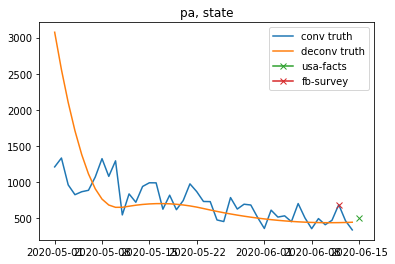

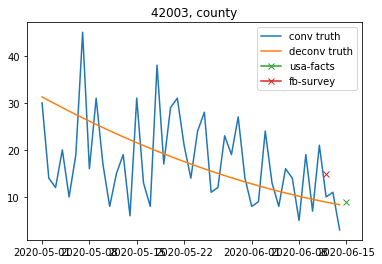

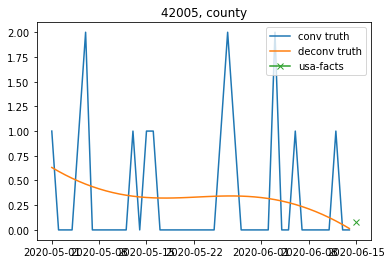

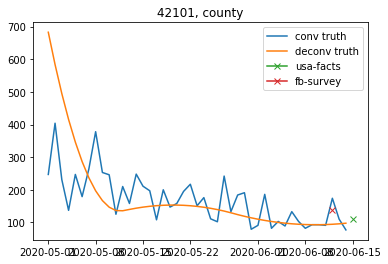

In [7]:
for signal in ground_truth:
    conv_truth = TempEpidata.get_signal_range(
        convolved_truth_indicator.source,
        convolved_truth_indicator.signal,
        input_dates[0], input_dates[-1],
        signal.geo_type, signal.geo_value)
    
    
    train_dates = list(map(TempEpidata.to_date, signal.dates))

    plt.plot(train_dates, conv_truth.values, label="conv truth")
    plt.plot(train_dates, signal.values, label="deconv truth")
    
    for sensor_conf, sensor_list in out_sensors.items():
        for sensor_sig in sensor_list:
            if sensor_sig.geo_value == signal.geo_value and sensor_sig.geo_type == signal.geo_type:
                sensor_dates = list(map(TempEpidata.to_date, sensor_sig.dates))
                plt.plot(sensor_dates, sensor_sig.values, label=sensor_conf.source, marker="x")
        
    plt.title(f"{signal.geo_value}, {signal.geo_type}")
    plt.legend()
    plt.show()

In [8]:
def time_range(start_date: int, end_date: int):
    """ YYYYMMDD format"""
    start_date = TempEpidata.to_date(start_date)
    end_date = TempEpidata.to_date(end_date)
    date_range = full_dates = [start_date + datetime.timedelta(days=a)\
                               for a in range((end_date - start_date).days + 1)]
    return [int(d.strftime('%Y%m%d')) for d in full_dates]

def date_to_int(date):
    return int(date.strftime('%Y%m%d'))

In [9]:
## gen and store historical sensors
## warning!!!! this will take a few minutes to run!
# as_of_dates = time_range(20200501, 20200815)
# for i, as_of_date in enumerate(as_of_dates):
#     if i % 7 == 0: print(f"{as_of_date}...")
    
    
#     input_dates = time_range(date_to_int(TempEpidata.to_date(as_of_date) - datetime.timedelta(days=45)),
#                              as_of_date)
#     ground_truth = deconvolve_signal(convolved_truth_indicator, input_dates,
#                                      input_locations, np.array(kernel))
#     out_sensors = sensor.compute_sensors(as_of_date,
#                                          regression_indicators,
#                                          convolved_truth_indicator,
#                                          ground_truth,
#                                          True)

In [10]:
def _lead_date(date, lag):
    return int((datetime.datetime.strptime(str(date), "%Y%m%d") + datetime.timedelta(lag)).strftime("%Y%m%d"))

def get_historical_sensor(geo_value: str,
                          geo_type: str,
                          sensor: SignalConfig,
                          ref_date: int,
                          as_of_date: int,
                          receiving_dir: str = "./receiving",
                          verbose: bool = False):
    export_dir = os.path.join(receiving_dir, sensor.source)
    export_file = os.path.join(export_dir, f"{ref_date}_{geo_type}_{sensor.signal}.csv")
    if not os.path.isfile(export_file):
        if verbose: print(f"sensor file not found: {export_file}")
        return None
    
    with open(export_file) as f:
        reader = csv.reader(f, delimiter=',')
        header = next(reader, None)
        for row in reader:
            if row[1] == geo_value \
            and int(row[3]) == as_of_date:
                return float(row[2])
    
    if verbose: print(f"sensor value not found: {export_file}")
    return None

def get_historical_sensor_data(sensor_sig: SignalConfig,
                               geo_value: str,
                               geo_type: str,
                               end_date: int,
                               start_date: int):
    input_dates = time_range(start_date, end_date)
    dates = []
    values = []
    for ref_date in input_dates:
        issue_date = _lead_date(ref_date, sensor_sig.lag)
        sensor_val = get_historical_sensor(geo_value, geo_type, 
                                           sensor_sig, 
                                           ref_date, issue_date)
        
        if sensor_val:
            dates.append(ref_date)
            values.append(sensor_val)
        
    return LocationSeries(
            dates=dates,
            values=values,
            geo_value=geo_value,
            geo_type=geo_type
        )


def historical_sensors(start_date: int,
                       end_date: int,
                       sensors: List[SignalConfig],
                       ground_truths: List[LocationSeries],
                       ) -> DefaultDict[SignalConfig, List[LocationSeries]]:
    output = defaultdict(list)
    for location in ground_truths:
        for sensor in sensors:
            sensor_vals = get_historical_sensor_data(
                sensor, location.geo_value, location.geo_type, end_date, start_date
            )
#             all_dates = [int(i.strftime("%Y%m%d")) for i in date_range(str(start_date), str(end_date))]
#             missing_dates = [i for i in all_dates if i not in sensor_vals.dates]
            if not sensor_vals.empty:
                output[sensor].append(sensor_vals)
    return output


# for location in ground_truth:
#     for ref_date in input_dates:
#         sensor_sig = regression_indicators[0]
#         issue_date = _lead_date(ref_date, sensor_sig.lag)
#         sensor_val = get_historical_sensor(location.geo_value,
#                                            location.geo_type,
#                                            regression_indicators[0], 
#                                            ref_date, issue_date)
#         print(ref_date, issue_date, location.geo_value, sensor_val)

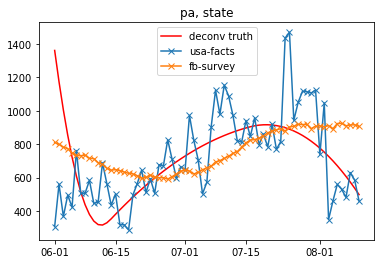

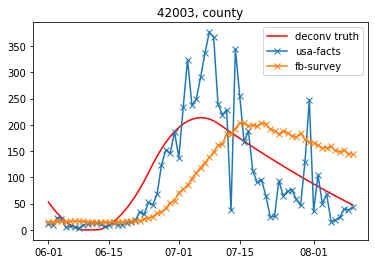

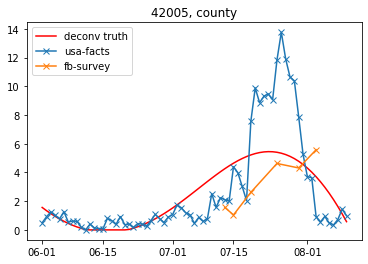

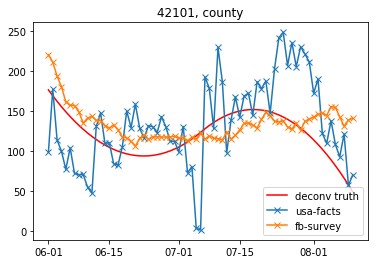

In [11]:
input_dates = time_range(20200601, 20200810)
nowcast_date = 20200810

ground_truth = deconvolve_signal(convolved_truth_indicator, input_dates,
                                 input_locations, np.array(kernel))
train_sensors = historical_sensors(input_dates[0], input_dates[-1],
                                  sensor_indicators, ground_truth)
now_sensors = historical_sensors(nowcast_date, nowcast_date,
                                 sensor_indicators, ground_truth)

# plot
for signal in ground_truth:
    conv_truth = TempEpidata.get_signal_range(
        convolved_truth_indicator.source,
        convolved_truth_indicator.signal,
        input_dates[0], input_dates[-1],
        signal.geo_type, signal.geo_value)
    
    plt.plot(list(map(TempEpidata.to_date, signal.dates)), 
             signal.values, label="deconv truth", color="red")
    
    for sensor_conf, sensor_list in train_sensors.items():
        for sensor_sig in sensor_list:
            if sensor_sig.geo_value == signal.geo_value and sensor_sig.geo_type == signal.geo_type:
                sensor_dates = list(map(TempEpidata.to_date, sensor_sig.dates))
                plt.plot(sensor_dates, sensor_sig.values, label=sensor_conf.source, marker="x")
        
    plt.title(f"{signal.geo_value}, {signal.geo_type}")
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.legend()
    plt.show()

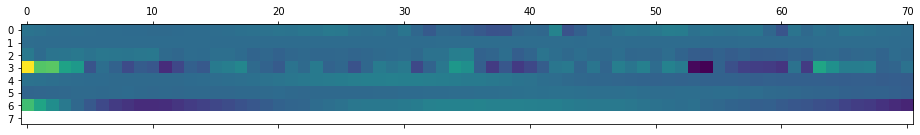

In [12]:
# move to matrix form
y = dict(((s.geo_value, s.geo_type), s) for s in ground_truth)
n_sensor_locs = len(sensor_indicators) * len(input_locations)
noise = np.full((len(input_dates), n_sensor_locs), np.nan)
z = np.full((1, n_sensor_locs), np.nan)
valid_location_types = []
j = 0
for sensor in sensor_indicators:
    # convert to dict indexed by loc to make matching across train/now easier
    train_series = dict(((s.geo_value, s.geo_type), s) for s in train_sensors[sensor])
    now_series = dict(((s.geo_value, s.geo_type), s) for s in now_sensors[sensor])
    valid_locs = set(train_series.keys()) & set(now_series.keys())

    for loc in sorted(valid_locs):
        dates_intersect = sorted(set(y[loc].dates) & set(train_series[loc].dates))
        inds = [i for i, date in enumerate(dates_intersect) if date in input_dates]
        y_vals = y[loc].get_data_range(dates_intersect[0], dates_intersect[-1])
        s_vals = train_series[loc].get_data_range(dates_intersect[0], dates_intersect[-1])
        noise[inds, j] = np.array(y_vals) - np.array(s_vals)
        z[:, j] = now_series[loc].values
        valid_location_types.append(loc)
        j += 1
        
plt.matshow(noise.T)
plt.show()

In [13]:
# cull nan columns
finite_cols = np.logical_and(np.any(np.isfinite(noise), axis=0),
                             np.all(np.isfinite(z), axis=0))

noise = noise[:, finite_cols]
z = z[:, finite_cols]

# todo: fill in missing rows
print(noise.shape, z.shape)

if len(valid_location_types) != noise.shape[1]:
    raise Exception('mismatched input locations and sensor matrix')

# determine statespace
H, W, output_locations = generate_statespace('pa', valid_location_types)

# estimate covariance
R = covariance.mle_cov(noise, covariance.BlendDiagonal2)

# run SF
x, P = fusion.fuse(z, R, H)
y, S = fusion.extract(x, P, W)
stdev = np.sqrt(np.diag(S)).reshape(y.shape)


(71, 7) (1, 7)
coalesce statespace...


In [14]:
out_preds = dict(zip(output_locations, y[0]))

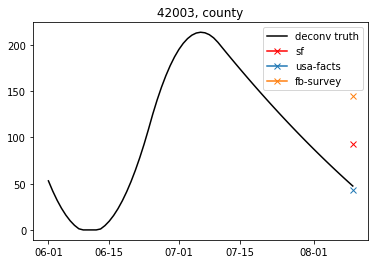

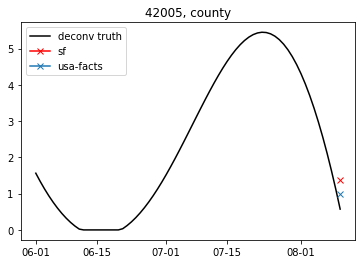

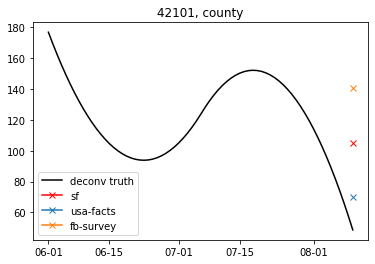

In [17]:
for signal in ground_truth:
    conv_truth = TempEpidata.get_signal_range(
        convolved_truth_indicator.source,
        convolved_truth_indicator.signal,
        input_dates[0], input_dates[-1],
        signal.geo_type, signal.geo_value)
    
    loc_tuple = (signal.geo_value, signal.geo_type)
    if loc_tuple in out_preds:
        plt.plot(list(map(TempEpidata.to_date, signal.dates)), 
                 signal.values, label="deconv truth", color="black")
        plt.plot(TempEpidata.to_date(nowcast_date), 
                 out_preds[loc_tuple], label="sf", marker="x", color="red")
        for sensor_conf, sensor_list in now_sensors.items():
            for sensor_sig in sensor_list:
                if sensor_sig.geo_value == signal.geo_value and sensor_sig.geo_type == signal.geo_type:
                    sensor_dates = list(map(TempEpidata.to_date, sensor_sig.dates))
                    plt.plot(sensor_dates, sensor_sig.values, label=sensor_conf.source, marker="x")

        plt.title(f"{signal.geo_value}, {signal.geo_type}")
        plt.gca().xaxis.set_major_formatter(myFmt)
        plt.legend()
        plt.show()